In [34]:
# import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import load_config

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']
STORIES = cfg['STORIES']

subject = 'sub-004'
task = 'treasureisland'

tr = 1.5

In [35]:
# load roi data
from utils import load_roi, get_embeddings, downsample_embeddings_lanczos, make_delayed

roi_data, roi_labels = load_roi(DATADIR, subject, task)
roi_labels = [label.decode('utf-8') for label in roi_labels]
n_rois = roi_data.shape[0]

# trim wait period (12 seconds = 8 TRs)
ydata = roi_data[:, 8:]

embs, starts, stops = get_embeddings(task)
n_features = embs.shape[-1]
xdata = downsample_embeddings_lanczos(embs, starts, stops, ydata.shape[-1], tr)


[INFO] utils.load_embeddings - Loading: /Users/gio/projects/ds_fmri/data/derivatives/english1000sm.hf5


[INFO] utils.load_embeddings - data shape: (985, 10470)
[INFO] utils.load_embeddings - vocab len: 10470
[INFO] utils.get_embeddings - 1672/1763 (missing 91) story tokens found in vocab.


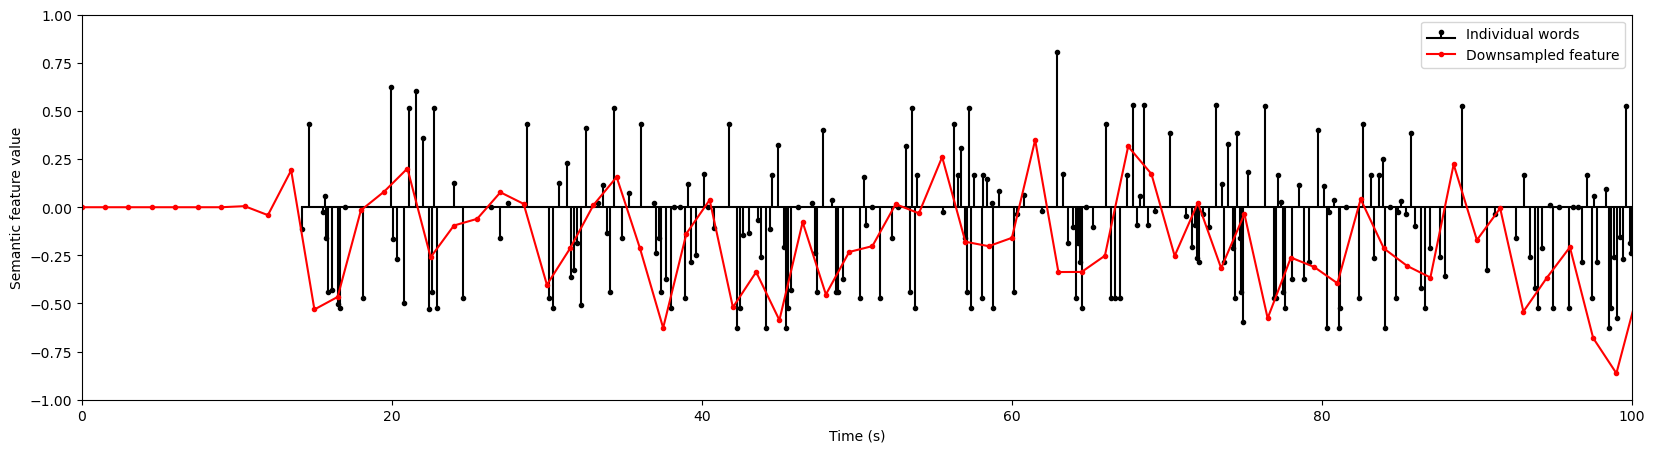

In [36]:
from matplotlib.pyplot import figure
f = figure(figsize=(20,5))
f.clf()
schan = 1
ax = f.add_subplot(1,1,1)
wordstems = ax.stem((starts + stops) / 2, 
                    embs[:,schan] / np.abs(embs[:,schan]).max(), 
                    linefmt="k-", markerfmt="k.", basefmt="k-")
interps = ax.plot(np.arange(xdata.shape[0]) * tr, 
                  xdata[:,schan] / np.abs(xdata[:,schan]).max(), 'r.-')
ax.set_xlim(0, 100)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));

In [37]:
# first, trim the data that have zero embeddings (music in the beginning, silence in the end)
idx_valid = np.where(np.sum(xdata, axis=1) != 0)[0]
xdata = xdata[idx_valid]
ydata = ydata[:, idx_valid]

# zscore each feature
xdata = (xdata - np.mean(xdata, axis=0, keepdims=True)) / np.std(xdata, axis=0, keepdims=True)

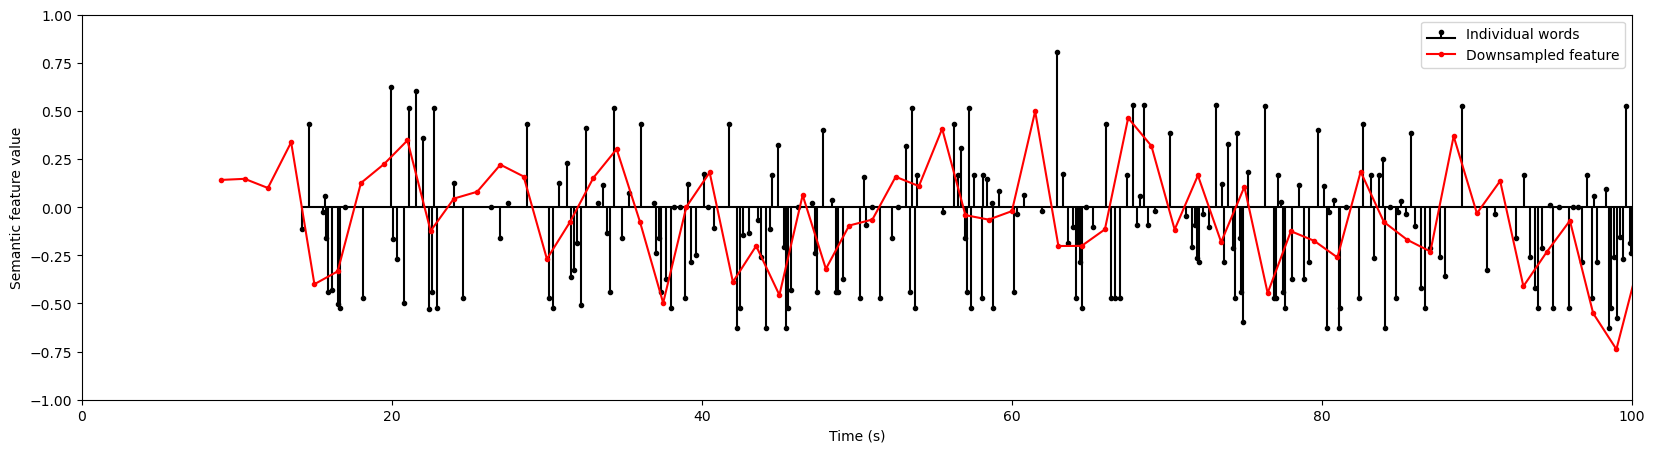

In [38]:
from matplotlib.pyplot import figure
f = figure(figsize=(20,5))
f.clf()
schan = 1
ax = f.add_subplot(1,1,1)
wordstems = ax.stem((starts + stops) / 2, 
                    embs[:,schan] / np.abs(embs[:,schan]).max(), 
                    linefmt="k-", markerfmt="k.", basefmt="k-")
interps = ax.plot(idx_valid * tr, 
                  xdata[:,schan] / np.abs(xdata[:,schan]).max(), 'r.-')
ax.set_xlim(0, 100)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));

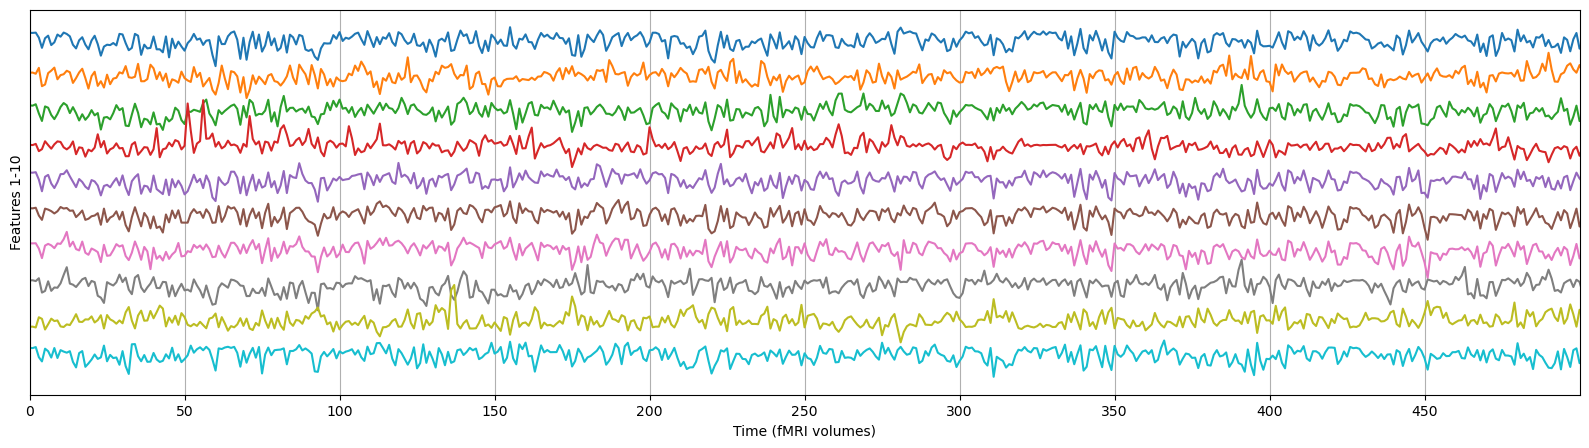

In [39]:
# Plot some of the combined stimuli
f = figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(10):
    # Plot each feature, offset by 5 vertically so they are easier to see
    ax.plot(xdata[:750,ii] - 5 * ii)

ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

In [40]:
# shift the embeddings to account for hemodynamic delay
n_delays = 5
delxdata = make_delayed(xdata, np.arange(1, n_delays + 1), circpad=False)

# zscore ydata
ydata = (ydata - np.mean(ydata, axis=1, keepdims=True)) / np.std(ydata, axis=1, keepdims=True)

print(delxdata.shape, ydata.shape)

(546, 4925) (200, 546)


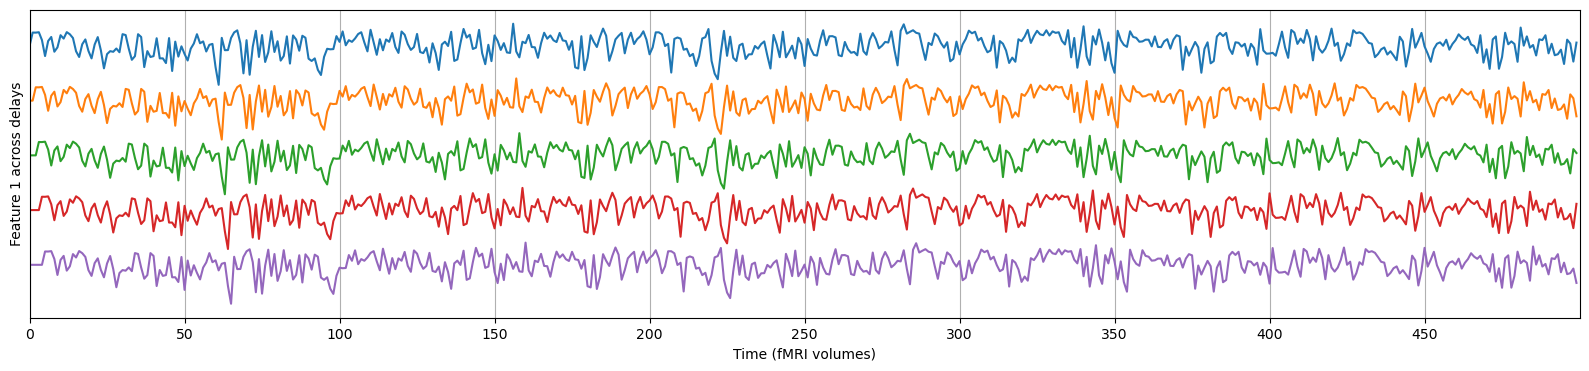

In [41]:
# Plot the same feature at different delays
f = figure(figsize=(20, 4))
ax = f.add_subplot(1,1,1)
for ii in range(n_delays):
    ax.plot(delxdata[:500, ii * embs.shape[1]] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Feature 1 across delays")
ax.grid()

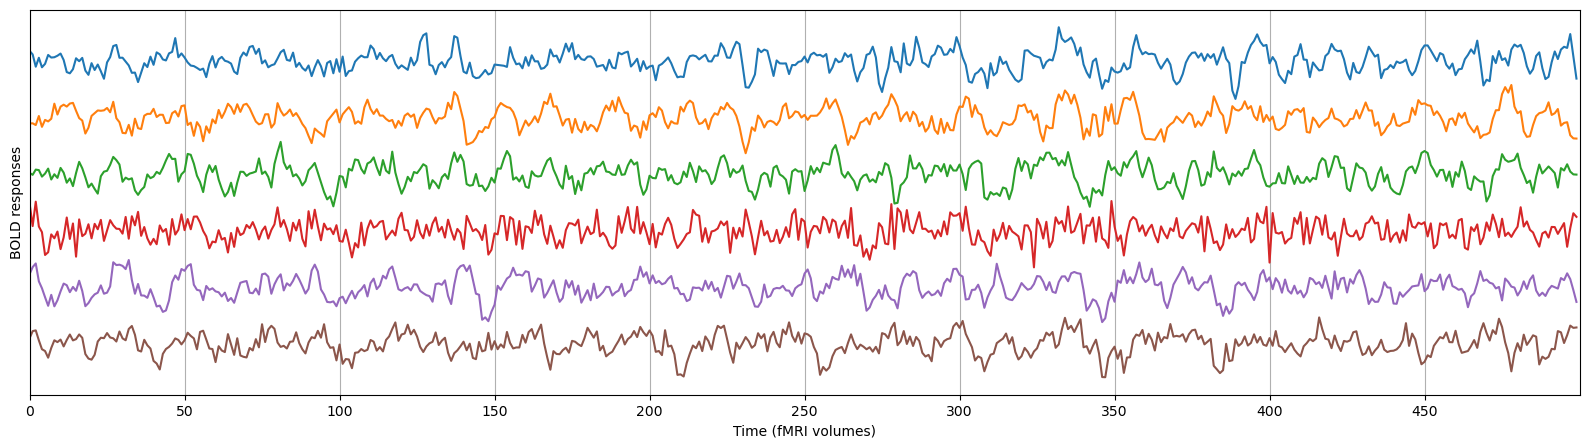

In [42]:
# Plot the response of a few rois over time
selrois = [24, 36, 40, 51, 60, 87]

f = figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)
for ii,vi in enumerate(selrois):
    ax.plot(ydata[vi, :500] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("BOLD responses")
ax.grid()

In [43]:
# Run regression
from ridge import bootstrap_ridge
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

permuted_inds = np.random.permutation(ydata.shape[1])
test_idx = permuted_inds[:ydata.shape[1] // 5]
train_idx = permuted_inds[ydata.shape[1] // 5:]
delRstim = delxdata[train_idx, :]
delPstim = delxdata[test_idx, :]
zRresp = ydata[:, train_idx].T
zPresp = ydata[:, test_idx].T

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, zRresp, delPstim, zPresp,
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)

pred = np.dot(delPstim, wt)

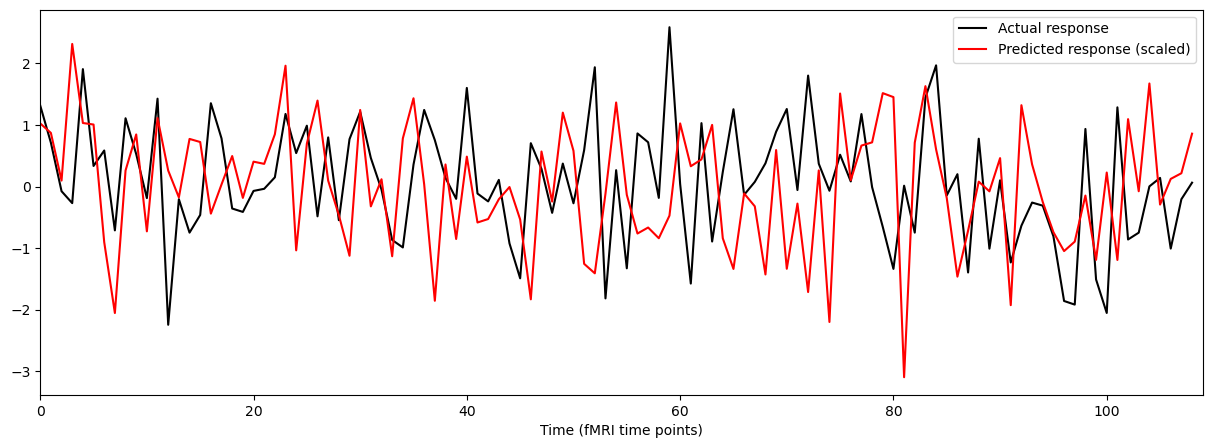

In [44]:
from utils import zscore
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 40

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(zscore(pred[:,selvox]), 'r')[0]

ax.set_xlim(0, zPresp.shape[0])
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response (scaled)"));

In [46]:
# regression; leave-one-story-out
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

n_splits = 10
alphas = np.logspace(-3, 3, 7)

weights = np.zeros((n_splits, n_rois, n_features * n_delays))
encperf = np.zeros((n_splits, n_rois))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

for ifold, (train_idx, test_idx) in enumerate(kf.split(xdata)):
    X_train, X_test = delxdata[train_idx], delxdata[test_idx]
    y_train, y_test = ydata[:, train_idx].T, ydata[:, test_idx].T

    model = RidgeCV(alphas=alphas, alpha_per_target=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test).T

    weights[ifold] = model.coef_
    encperf[ifold] = np.diag(np.corrcoef(y_test.T, y_pred)[n_rois:, :n_rois])


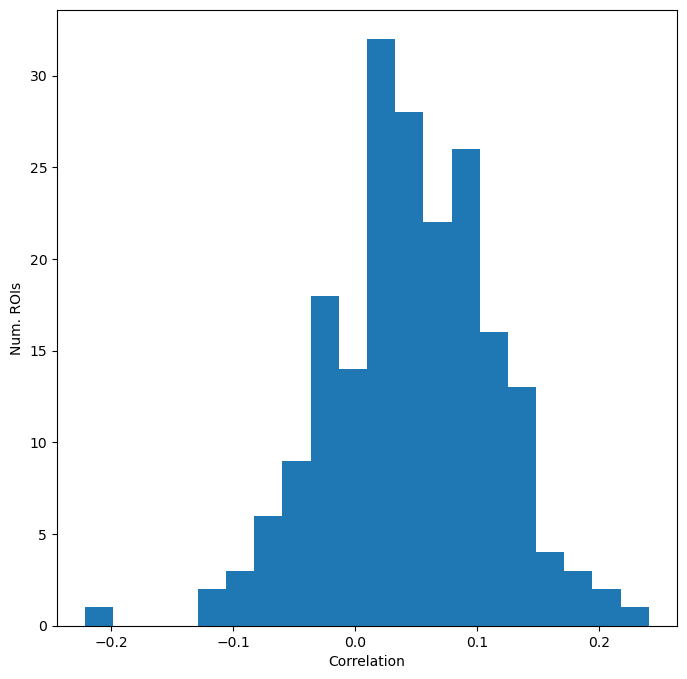

In [50]:
f = figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.hist(encperf.mean(0), 20) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. ROIs");

17Networks_LH_DefaultB_Temp_2: 0.24065777964310947
17Networks_LH_DefaultB_PFCd_1: 0.20453833149855843
17Networks_RH_LimbicB_OFC_3: 0.1999344754537339
17Networks_RH_LimbicB_OFC_4: 0.1941393845926102
17Networks_RH_VisCent_ExStr_3: 0.18974390496450624


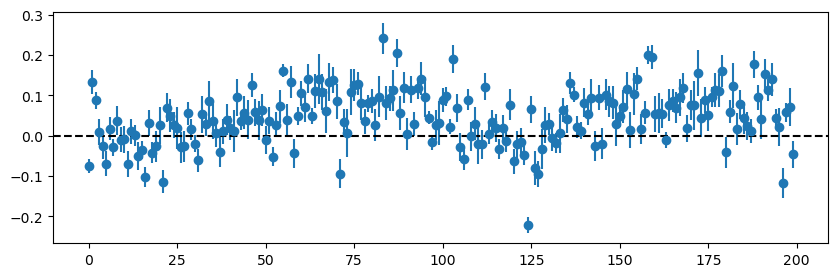

In [51]:
# plot mean and sem of encoding performance
plt.figure(figsize=(10, 3))
plt.errorbar(np.arange(len(roi_labels)), np.mean(encperf, axis=0), np.std(encperf, axis=0) / np.sqrt(n_splits), fmt='o')
# plt.plot(np.arange(len(roi_labels)), corr, 'ro')
plt.axhline(0, color='k', linestyle='--')

mean_encperf = np.mean(encperf, axis=0)
# print top 5 ROIs with highest mean encoding performance
top5 = np.argsort(np.mean(encperf, axis=0))[::-1][:5]
top5_huth = np.argsort(corr)[::-1][:5]
for i in range(5):
    print(f'{roi_labels[top5[i]]}: {np.mean(encperf, axis=0)[top5[i]]}')
    # print(f'{roi_labels[top5_huth[i]]}: {corr[top5_huth[i]]}')

# print(np.corrcoef(np.mean(encperf, axis=0), corr)[0,1])

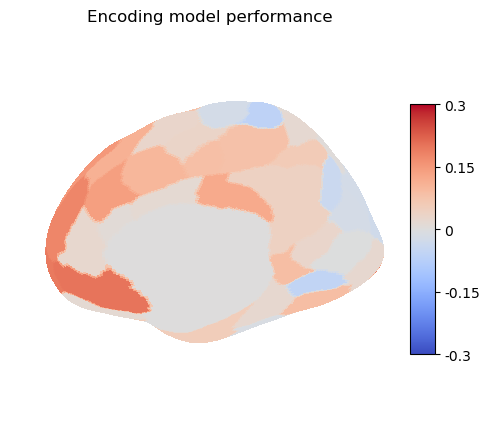

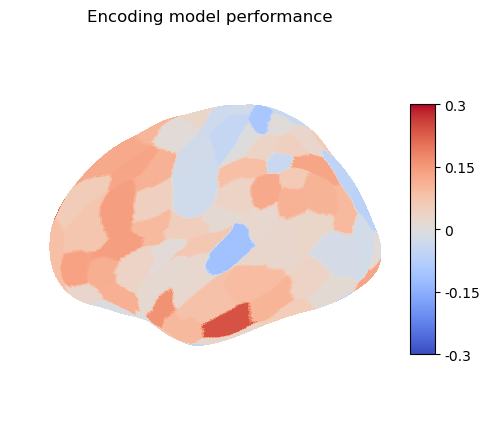

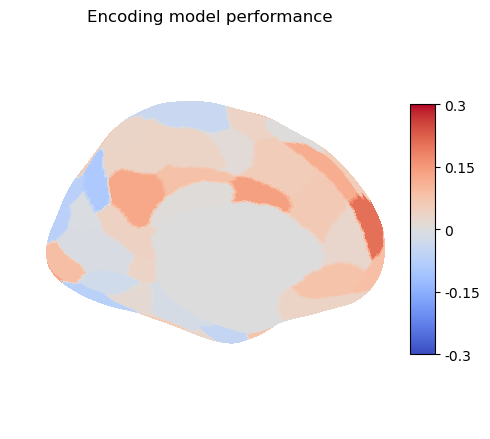

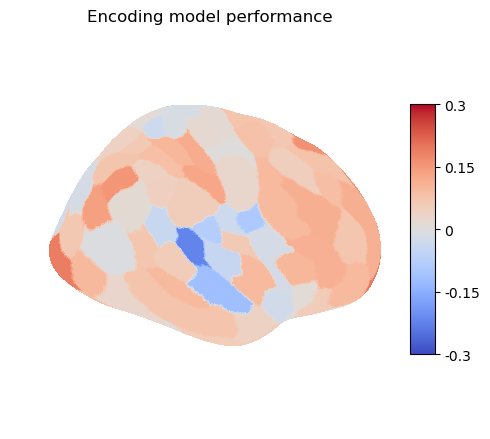

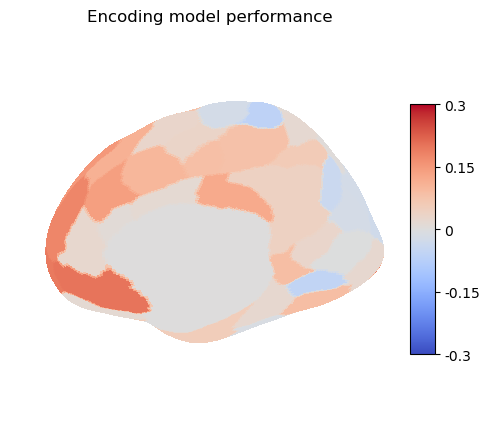

In [52]:
# plot encoding model performance on the brain
import nibabel as nib
from nilearn import datasets, plotting

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')

# left hemisphere
surf_labels, ctab, surf_names = nib.freesurfer.read_annot('/Users/gio/Downloads/lh.Schaefer2018_200Parcels_17Networks_order.annot')
surf_labels = surf_labels.astype(int)
surf_names = [name.decode('utf-8') for name in surf_names]

surf_score = np.zeros_like(surf_labels, dtype=float)
for ivertex, vertex_label in enumerate(surf_labels):
    if vertex_label == 0:
        continue
    roi_idx = roi_labels.index(surf_names[vertex_label])
    surf_score[ivertex] = mean_encperf[roi_idx]
    # surf_score[ivertex] = corr[roi_idx]

plotting.plot_surf_stat_map(fsaverage.infl_left, surf_score, hemi='left', title='Encoding model performance', colorbar=True, cmap='coolwarm', vmax=0.3, vmin=-0.3)

plotting.plot_surf_stat_map(fsaverage.infl_left, surf_score, hemi='left', title='Encoding model performance', colorbar=True, cmap='coolwarm', vmax=0.3, vmin=-0.3, view='medial')

# plt.savefig(os.path.join(FIGDIR, 'surf_isc_roi_R.png'))

# right hemisphere
surf_labels, ctab, surf_names = nib.freesurfer.read_annot('/Users/gio/Downloads/rh.Schaefer2018_200Parcels_17Networks_order.annot')
surf_labels = surf_labels.astype(int)
surf_names = [name.decode('utf-8') for name in surf_names]

surf_score = np.zeros_like(surf_labels, dtype=float)
for ivertex, vertex_label in enumerate(surf_labels):
    if vertex_label == 0:
        continue
    roi_idx = roi_labels.index(surf_names[vertex_label])
    surf_score[ivertex] = mean_encperf[roi_idx]
    # surf_score[ivertex] = corr[roi_idx]

plotting.plot_surf_stat_map(fsaverage.infl_right, surf_score, hemi='right', title='Encoding model performance', colorbar=True, cmap='coolwarm', vmax=0.3, vmin=-0.3)

plotting.plot_surf_stat_map(fsaverage.infl_right, surf_score, hemi='right', title='Encoding model performance', colorbar=True, cmap='coolwarm', vmax=0.3, vmin=-0.3, view='medial')
